# Classificação de Sentimentos com SVM + Bag of Words

Este notebook implementa um classificador de sentimentos para avaliações de estabelecimentos utilizando:
- **SVM (Support Vector Machine)**: algoritmo de aprendizado supervisionado para classificação
- **BoW (Bag of Words)**: técnica de representação de texto que converte documentos em vetores de frequência de palavras

## Objetivo
Classificar avaliações de estabelecimentos como positivas ou negativas com base no texto.

## 1. Importação de Bibliotecas

Importando as bibliotecas necessárias para processamento de texto, vetorização, modelagem e avaliação.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import string

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Carregamento dos Dados

Carregando o dataset de avaliações de restaurantes para análise e treinamento do modelo.

In [3]:
# Carregando o dataset do Yelp
df = pd.read_csv('dataset/yelp_reviews.csv', names=['label', 'text'])

print(f"Dimensões do dataset: {df.shape}")
print(f"\nPrimeiras linhas:")
df.head()

,label,text
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


## 3. Exploração Inicial dos Dados

Análise exploratória para entender a estrutura do dataset, identificar colunas relevantes e verificar a qualidade dos dados.

In [4]:
# Informações sobre o dataset
print("Informações do Dataset:")
print(df.info())
print("\n" + "="*50 + "\n")

# Verificar valores nulos
print("Valores Nulos:")
print(df.isnull().sum())
print("\n" + "="*50 + "\n")

# Distribuição das classes
print("Distribuição das Classes:")
print(df['label'].value_counts())
print("\n" + "="*50 + "\n")

# Estatísticas do texto
df['text_length'] = df['text'].apply(len)
print("Estatísticas do Comprimento do Texto:")
print(df['text_length'].describe())

Informações do Dataset:
<class 'pandas.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   38000 non-null  int64
 1   text    38000 non-null  str  
dtypes: int64(1), str(1)
memory usage: 593.9 KB
None


Valores Nulos:
label    0
text     0
dtype: int64


Distribuição das Classes:
label
2    19000
1    19000
Name: count, dtype: int64


Estatísticas do Comprimento do Texto:
count    38000.000000
mean       723.237684
std        661.465021
min          4.000000
25%        280.000000
50%        527.000000
75%        943.000000
max       5093.000000
Name: text_length, dtype: float64


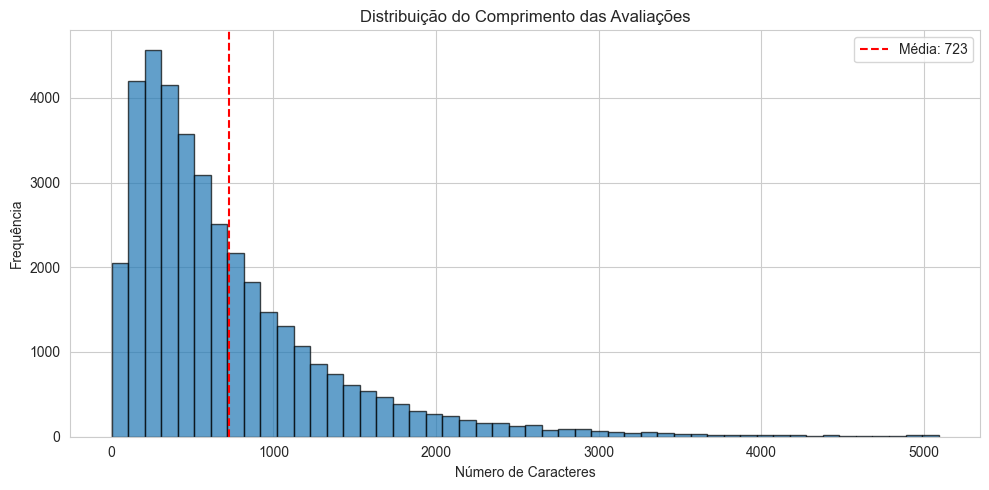

In [5]:
# Visualização da distribuição das classes
plt.figure(figsize=(8, 5))
label_counts = df['label'].value_counts()
plt.bar(['Negativo (1)', 'Positivo (2)'], label_counts.values, color=['#e74c3c', '#2ecc71'])
plt.title('Distribuição das Classes no Dataset')
plt.ylabel('Quantidade de Avaliações')
plt.xlabel('Sentimento')
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# Visualização da distribuição do comprimento dos textos
plt.figure(figsize=(10, 5))
plt.hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribuição do Comprimento das Avaliações')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')
plt.axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Média: {df["text_length"].mean():.0f}')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Pré-processamento de Texto

O pré-processamento é fundamental para melhorar a qualidade dos features extraídos. Vamos implementar uma função de limpeza que:
- Converte texto para minúsculas
- Remove pontuação
- Remove números
- Remove espaços extras

In [6]:
def preprocess_text(text):
    """
    Função para pré-processar texto de avaliações
    """
    # Converter para minúsculas
    text = text.lower()
    
    # Remover números
    text = re.sub(r'\d+', '', text)
    
    # Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remover espaços extras
    text = ' '.join(text.split())
    
    return text

# Aplicar pré-processamento
df['text_clean'] = df['text'].apply(preprocess_text)

# Comparar texto original e processado
print("Exemplo de texto original:")
print(df['text'].iloc[0][:200])
print("\n" + "="*50 + "\n")
print("Texto após pré-processamento:")
print(df['text_clean'].iloc[0][:200])

Exemplo de texto original:
Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Bo


Texto após pré-processamento:
contrary to other reviews i have zero complaints about the service or the prices i have been getting tire service here for the past years now and compared to my experience with places like pep boys th


## 5. Criação do Bag of Words (BoW)

O Bag of Words é uma técnica de representação de texto que:
- Cria um vocabulário com todas as palavras únicas do corpus
- Transforma cada documento em um vetor de contagem de palavras
- Ignora a ordem das palavras, focando apenas na frequência

Vamos usar o `CountVectorizer` do scikit-learn com os seguintes parâmetros:
- `max_features`: limitar ao vocabulário mais comum para reduzir dimensionalidade
- `stop_words='english'`: remover palavras comuns sem valor semântico

In [7]:
# Criar o vetorizador BoW
vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# Transformar o texto em matriz de features
X = vectorizer.fit_transform(df['text_clean'])
y = df['label']

print(f"Forma da matriz de features: {X.shape}")
print(f"Número de documentos: {X.shape[0]}")
print(f"Tamanho do vocabulário: {X.shape[1]}")
print(f"\nExemplo de palavras no vocabulário (primeiras 20):")
print(vectorizer.get_feature_names_out()[:20])

Forma da matriz de features: (38000, 5000)
Número de documentos: 38000
Tamanho do vocabulário: 5000

Exemplo de palavras no vocabulário (primeiras 20):
['aber' 'ability' 'able' 'absolute' 'absolutely' 'ac' 'accent' 'accept'
 'acceptable' 'accepted' 'access' 'accessible' 'accessories' 'accident'
 'accidentally' 'accommodate' 'accommodating' 'accompanied' 'accompanying'
 'according']


## 6. Divisão dos Dados em Treino e Teste

Dividindo o dataset em conjuntos de treino (80%) e teste (20%) para avaliar a capacidade de generalização do modelo.

In [8]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")
print(f"\nDistribuição de classes no treino:")
print(y_train.value_counts())
print(f"\nDistribuição de classes no teste:")
print(y_test.value_counts())

Tamanho do conjunto de treino: 30400 amostras
Tamanho do conjunto de teste: 7600 amostras

Distribuição de classes no treino:
label
2    15200
1    15200
Name: count, dtype: int64

Distribuição de classes no teste:
label
1    3800
2    3800
Name: count, dtype: int64


## 7. Treinamento do Modelo SVM

O Support Vector Machine (SVM) é um algoritmo poderoso para classificação que:
- Encontra o hiperplano que melhor separa as classes
- Funciona bem em espaços de alta dimensionalidade (como BoW)
- É eficaz mesmo quando o número de features é maior que o número de amostras

Vamos treinar um SVM linear e também usar GridSearchCV para encontrar os melhores hiperparâmetros.

In [9]:
# Treinar modelo SVM inicial
print("Treinando modelo SVM com kernel linear...")
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

print("Modelo treinado com sucesso!")
print(f"\nNúmero de vetores de suporte: {svm_model.n_support_}")
print(f"Vetores de suporte por classe: {dict(zip([1, 2], svm_model.n_support_))}")

Modelo treinado com sucesso!

Número de vetores de suporte: [3219 3148]
Vetores de suporte por classe: {1: np.int32(3219), 2: np.int32(3148)}


### 7.1 Otimização de Hiperparâmetros com GridSearchCV

Vamos usar validação cruzada para encontrar os melhores valores para:
- `C`: parâmetro de regularização (controla o trade-off entre margem e erro)
- `kernel`: tipo de kernel (linear, rbf, poly)

In [ ]:
# Definir grid de hiperparâmetros
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Grid Search com validação cruzada
print("Executando Grid Search (pode levar alguns minutos)...")
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)
print(f"\nMelhor score na validação cruzada: {grid_search.best_score_:.4f}")

# Usar o melhor modelo
best_svm = grid_search.best_estimator_

Executando Grid Search (pode levar alguns minutos)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


## 8. Avaliação do Modelo

Avaliando o desempenho do modelo otimizado no conjunto de teste usando múltiplas métricas.

In [ ]:
# Fazer predições no conjunto de teste
y_pred = best_svm.predict(X_test)

# Calcular acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\n" + "="*50 + "\n")

# Relatório de classificação completo
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Negativo (1)', 'Positivo (2)']))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusão:")
print(cm)

In [ ]:
# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo (1)', 'Positivo (2)'],
            yticklabels=['Negativo (1)', 'Positivo (2)'])
plt.title('Matriz de Confusão - SVM + BoW')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.tight_layout()
plt.show()

# Calcular e mostrar taxas de erro
tn, fp, fn, tp = cm.ravel()
print(f"\nVerdadeiros Negativos: {tn}")
print(f"Falsos Positivos: {fp}")
print(f"Falsos Negativos: {fn}")
print(f"Verdadeiros Positivos: {tp}")
print(f"\nTaxa de Falso Positivo: {fp/(fp+tn):.4f}")
print(f"Taxa de Falso Negativo: {fn/(fn+tp):.4f}")

## 9. Análise de Resultados e Predições

Testando o modelo com exemplos reais para verificar sua capacidade de classificar novos textos.

In [ ]:
# Função para predizer sentimento de novos textos
def predict_sentiment(text):
    """
    Prediz o sentimento de um texto
    """
    # Pré-processar
    text_clean = preprocess_text(text)
    
    # Vetorizar
    text_vec = vectorizer.transform([text_clean])
    
    # Predizer
    prediction = best_svm.predict(text_vec)[0]
    
    sentiment = "Positivo" if prediction == 2 else "Negativo"
    return sentiment, prediction

# Testar com exemplos novos
test_reviews = [
    "This place is amazing! Best food I've ever had. Highly recommend!",
    "Terrible service, cold food, and overpriced. Never coming back.",
    "It was okay, nothing special but not bad either.",
    "Absolutely loved it! The staff was friendly and the atmosphere was great.",
    "Worst experience ever. Waited for an hour and the food was disgusting."
]

print("Predições para Novos Textos:")
print("="*70)
for i, review in enumerate(test_reviews, 1):
    sentiment, label = predict_sentiment(review)
    print(f"\n{i}. Texto: {review}")
    print(f"   Sentimento: {sentiment} (label={label})")

### 9.1 Análise de Erros

Vamos examinar alguns exemplos onde o modelo errou para entender suas limitações.

In [ ]:
# Identificar predições incorretas
incorrect_predictions = y_test != y_pred
incorrect_indices = y_test[incorrect_predictions].index

print(f"Total de predições incorretas: {incorrect_predictions.sum()}")
print(f"Taxa de erro: {incorrect_predictions.sum() / len(y_test):.4f}\n")

# Mostrar alguns exemplos de erros
print("Exemplos de Classificações Incorretas:")
print("="*70)

num_examples = min(5, len(incorrect_indices))
for i, idx in enumerate(incorrect_indices[:num_examples], 1):
    true_label = y_test.loc[idx]
    pred_label = y_pred[list(y_test.index).index(idx)]
    text = df.loc[idx, 'text']
    
    true_sentiment = "Positivo" if true_label == 2 else "Negativo"
    pred_sentiment = "Positivo" if pred_label == 2 else "Negativo"
    
    print(f"\nExemplo {i}:")
    print(f"Texto: {text[:150]}...")
    print(f"Real: {true_sentiment} ({true_label}) | Predito: {pred_sentiment} ({pred_label})")

## 10. Conclusões

### Resumo do Modelo
- **Algoritmo**: Support Vector Machine (SVM) com kernel otimizado
- **Representação**: Bag of Words (BoW) com 5000 features
- **Dataset**: Avaliações do Yelp com classificação binária (positivo/negativo)

### Pontos Fortes
1. Boa performance em textos com linguagem clara e objetiva
2. Rápido para treinar e fazer predições
3. Funciona bem com representação esparsa (BoW)
4. Interpretável através da análise de features importantes

### Limitações
1. Bag of Words ignora a ordem das palavras e contexto
2. Não captura nuances como sarcasmo ou ironia
3. Avaliações mistas (positivas e negativas no mesmo texto) podem confundir o modelo
4. Dependente da qualidade do pré-processamento

### Possíveis Melhorias
1. Usar TF-IDF ao invés de BoW simples
2. Incorporar n-gramas (bigramas, trigramas)
3. Experimentar com embeddings (Word2Vec, GloVe)
4. Testar modelos mais avançados (LSTM, BERT)
5. Adicionar features adicionais (comprimento do texto, pontuação, etc.)